In [1]:
import os
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2
from torchvision.models import swin_v2_b

In [2]:
md_df = pd.read_csv('data/spec_sample.csv')
md_df

,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,...,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,PETROMAGERR_I,PETROMAGERR_Z,asset_id
0,1.802675e+18,NaN,588017703996096547,160.990400,11.703790,10:43:57.70,+11:42:13.6,original,SBb?t,44,...,11.404507,10.609171,10.190607,9.942420,0.011781,0.017716,0.015589,0.014794,0.001695,217750
1,1.992984e+18,NaN,587738569780428805,192.410830,15.164207,12:49:38.60,+15:09:51.1,original,Ser,45,...,11.738226,10.887243,10.544050,10.306449,0.069332,0.003513,0.032395,0.007165,0.028602,112436
2,1.489569e+18,NaN,587735695913320507,210.802200,54.348953,14:03:12.53,+54:20:56.2,original,Sc+t,46,...,11.370230,10.874486,10.793258,10.483679,0.557220,0.395333,0.305245,0.231762,0.213732,86566
3,2.924084e+18,1.237668e+18,587742775634624545,185.303420,18.382704,12:21:12.82,+18:22:57.7,original,SBc(r),45,...,12.237144,11.199432,10.773752,10.581368,0.046263,0.017666,0.031946,0.009603,0.013819,182364
4,1.387165e+18,1.237658e+18,587732769983889439,187.366790,8.749928,12:29:28.03,+08:44:59.7,extra,Ser,49,...,12.006036,11.179650,10.755026,10.542995,0.016208,0.069274,0.078893,0.069782,0.042792,252712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243429,2.013145e+18,1.237664e+18,587737807967092857,145.174330,63.154312,09:40:41.84,+63:09:15.5,original,Sc2l,35,...,17.999409,17.100555,16.675460,16.408205,0.224825,0.019980,0.013742,0.015222,0.043520,105335
243430,3.333027e+17,1.237649e+18,588848898847605001,199.857380,-1.037356,13:19:25.77,-01:02:14.5,original,Sb,40,...,18.017294,17.068018,16.662252,16.369007,0.176710,0.017176,0.010603,0.010926,0.027732,242095
243431,1.959147e+18,1.237661e+18,587735348018872369,139.620040,10.317866,09:18:28.81,+10:19:04.3,original,Ei(o),49,...,17.188522,17.138435,16.988346,16.762678,0.060965,0.037028,0.051036,0.053011,0.039715,80714
243432,4.673293e+17,1.237660e+18,588015508218577115,52.470364,-0.750249,03:29:52.89,+00:45:00.9,stripe82,Er,43,...,18.432096,17.298166,16.812576,16.353765,0.313868,0.030281,0.017445,0.019761,0.031545,290330


In [3]:
for feature in list(md_df.columns):
    print(feature)

specobjid
dr8objid
dr7objid
ra
dec
rastring
decstring
sample
gz2class
total_classifications
total_votes
t01_smooth_or_features_a01_smooth_count
t01_smooth_or_features_a01_smooth_weight
t01_smooth_or_features_a01_smooth_fraction
t01_smooth_or_features_a01_smooth_weighted_fraction
t01_smooth_or_features_a01_smooth_debiased
t01_smooth_or_features_a01_smooth_flag
t01_smooth_or_features_a02_features_or_disk_count
t01_smooth_or_features_a02_features_or_disk_weight
t01_smooth_or_features_a02_features_or_disk_fraction
t01_smooth_or_features_a02_features_or_disk_weighted_fraction
t01_smooth_or_features_a02_features_or_disk_debiased
t01_smooth_or_features_a02_features_or_disk_flag
t01_smooth_or_features_a03_star_or_artifact_count
t01_smooth_or_features_a03_star_or_artifact_weight
t01_smooth_or_features_a03_star_or_artifact_fraction
t01_smooth_or_features_a03_star_or_artifact_weighted_fraction
t01_smooth_or_features_a03_star_or_artifact_debiased
t01_smooth_or_features_a03_star_or_artifact_flag
t0

In [3]:
img_width = 512
img_height = 512
n_channels = 3

class GalaxyZooDateset(torch.utils.data.Dataset):

    def __init__(self, csv_path='data/spec_sample.csv', img_path='data/3565489/images', include_images=False):

        self.csv_path = csv_path
        self.img_path = img_path
        self.include_images = include_images
        
        self.df = pd.read_csv(csv_path)
            
    def get_image_tensor(self, asset_id):       

        im = cv2.imread(f"{self.img_path}/{asset_id}.jpg")
        im = np.array(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), dtype=np.float32)
        im = torch.from_numpy(np.permute_dims(im, (2, 0, 1)))
        return im

    def __len__(self):

        return self.df.shape[0]

    def __getitem__(self, index):        
        
        sample = {
            'dr7objid': self.df['dr7objid'][index],
            'class': self.df['gz2class'][index],
            'specz': self.df['REDSHIFT'][index],
            #'swin_embeddings':, # TODO: Add swin embedding after running the model
        }

        if self.include_images == True:

            asset_id = self.df['asset_id'][index]
            sample['image'] = self.get_image_tensor(asset_id)

        return sample

In [5]:
dataset = GalaxyZooDateset(include_images=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

  0%|                                                                                                                                                                       | 0/119 [00:00<?, ?it/s]

['dr7objid', 'class', 'specz', 'image']
torch.Size([2048, 3, 424, 424])


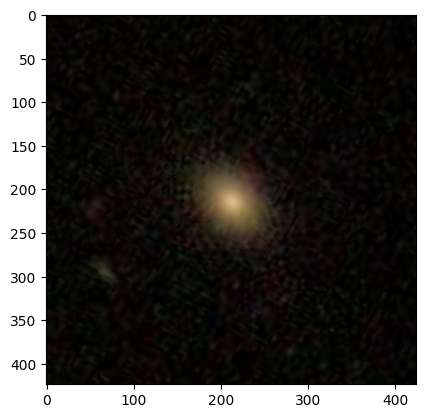

  0%|                                                                                                                                                                       | 0/119 [00:06<?, ?it/s]


In [31]:
for batch in tqdm(dataloader):
    print(list(batch.keys()))
    print(batch['image'].shape)
    plt.imshow(batch['image'][0].permute(1, 2, 0).numpy().astype(int))
    plt.show()
    break

In [12]:
class GalaxyMorophologyClassifier(torch.nn.Module):
        
    def __init__(self):

        super().__init__()

        self.swin = torch.hub.load("pytorch/vision", "swin_v2_t", weights="DEFAULT", progress=False)

        # Find a way to delete the last layer
        

    def forward(self, batch):

        images = batch['image']
        logits = self.swin(images)
        return logits

In [6]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = input[0].detach()
    return hook


model = torch.hub.load("pytorch/vision", "swin_v2_t", weights="DEFAULT", progress=False)
model.head.register_forward_hook(get_activation('head'))

Using cache found in /Users/vedshah/.cache/torch/hub/pytorch_vision_main


In [8]:
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
df_array = []
i = 0

for batch in tqdm(dataloader):

    print(batch['image'].dtype)
    
    logits = model(batch['image'])
    embeddings = activation['head']
    
    df = pd.DataFrame(embeddings, columns=[f"embedding_{e}" for e in range(embeddings.shape[1])])
    df['class'] = batch['class']
    df['dr7objid'] = batch['dr7objid']

    print(df)
    df_array.append(df)
    i += 1

    if i ==2:
        break
    
    #print(logits.shape)
    # print(embeddings.shape)
    # print(list(batch.keys()))
    # plt.imshow(batch['image'][0].permute(1, 2, 0).numpy().astype(int))
    # plt.show()

  0%|                                                                                                                                                                      | 0/7608 [00:00<?, ?it/s]

torch.float32


  0%|                                                                                                                                                           | 1/7608 [00:10<21:20:02, 10.10s/it]

    embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0      0.313013    -0.375482    -0.733018    -0.196580    -0.158814   
1      0.411287     0.415858    -0.238292    -0.604831    -0.683282   
2      0.433355     0.107951     0.027703    -0.444633    -0.607259   
3      0.670675     0.063013    -0.292085    -0.130882     0.502463   
4      0.380735     0.226123    -0.026190    -1.180227    -0.502519   
5     -0.122105    -0.191060    -0.318071    -0.405436    -0.337606   
6      0.477349    -0.395126    -0.187337    -0.282241    -0.314600   
7      0.114241     0.547055    -0.318322    -0.424963    -0.643776   
8      0.286727     0.603212    -0.273440    -0.590165    -0.237599   
9      0.367808     0.534253    -0.168528    -0.379158    -0.532905   
10     0.638866     0.346785    -0.218023    -0.561801    -0.692119   
11     0.273611     0.184190    -0.241984    -0.941360    -0.624558   
12     0.170788     0.169588    -0.579521    -0.405248    -0.474100   
13    

  0%|                                                                                                                                                           | 1/7608 [00:20<44:09:31, 20.90s/it]

    embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0      0.402878     0.401985    -0.033559    -0.523627    -0.568664   
1      0.179954     0.955879    -0.632829    -0.487063    -0.340465   
2      0.211565     0.596231     0.152879    -0.455025    -0.985922   
3      0.195198     0.263319    -0.875583    -0.735653    -0.184394   
4      0.348135     0.022994    -0.145522    -0.368240    -0.860541   
5      0.586914     0.329981    -0.104070    -0.432777    -0.817897   
6      0.494537     0.099232    -0.242685    -0.209940    -0.551768   
7      0.643112     0.117787    -0.217761    -0.519821    -0.691905   
8     -0.038849     0.024819    -0.284436    -0.109966    -0.806361   
9      0.187850     0.380646    -0.075697    -0.346091    -0.913371   
10     0.109345    -0.224509     0.371858     0.056285    -0.434803   
11     0.391652    -0.066282    -0.731699    -0.111778    -0.034381   
12     0.254838    -3.172963    -0.501148    -1.070092    -0.328696   
13    

In [9]:
embeddings_df = pd.concat(df_array)

In [10]:
embeddings_df.to_csv('embedding.csv')

In [11]:
embeddings_df

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,class,dr7objid
0,0.313013,-0.375482,-0.733018,-0.196580,-0.158814,0.082670,-0.046173,0.272498,0.799700,0.224444,...,-0.385158,0.069676,-0.082031,-0.608149,-0.121124,0.056921,0.751972,0.685565,SBb?t,587731499185537120
1,0.411287,0.415858,-0.238292,-0.604831,-0.683282,-0.069107,-0.016905,-0.010606,0.401985,0.391648,...,-0.256404,-0.163507,-0.305016,-0.143376,-0.068879,0.011448,0.095490,-0.206071,Sc?t(i),587739706887504238
2,0.433355,0.107951,0.027703,-0.444633,-0.607259,0.055377,-0.042011,-0.316274,0.926193,0.528499,...,-0.195425,0.056672,-0.422108,-0.252609,0.208735,0.115831,0.444037,0.296556,Er,587742190972436686
3,0.670675,0.063013,-0.292085,-0.130882,0.502463,0.291079,-0.063418,0.369036,0.081643,-0.263016,...,-0.400333,0.197382,-0.391080,-0.127186,0.054490,0.210894,0.197046,0.283438,Ser,587735666930352569
4,0.380735,0.226123,-0.026190,-1.180227,-0.502519,0.150567,-0.020874,0.177041,0.787977,0.739514,...,-0.386944,-0.257171,-0.120612,-0.524536,-0.156179,0.126453,0.723857,-0.053648,Sc2t,588016878828060847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0.606316,0.513846,-0.299077,-0.065134,-0.623593,0.346748,-0.039875,-0.095006,0.875222,0.406234,...,-0.414290,-0.068914,-0.605982,0.092364,-0.005439,0.040794,0.625589,0.253446,Sb2m,587729751676617472
28,0.178654,0.228208,-0.161290,-0.656040,-0.860275,-0.092844,-0.011637,-0.146584,0.635013,0.802301,...,-0.318084,-0.051153,-0.315417,-0.240066,-0.124519,0.032626,0.196644,0.450761,SBc(i),587742550678962280
29,0.588710,0.568217,-0.111125,-1.310257,-0.529960,0.132032,-0.056395,0.023936,0.468186,0.526764,...,-0.043603,-0.188679,-0.030084,-0.396424,0.007123,0.219763,0.867743,0.156224,Sb?t(i),587736584966504630
30,0.120952,-1.237834,-0.294523,-0.332992,0.365522,-0.430257,0.039536,-0.440290,0.974682,0.354778,...,-1.270950,1.054731,0.097008,0.321736,-0.264109,-0.285618,1.306225,-0.077917,Er,587741816236343632
